In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

sys.path.append('../python')

from mpl_settings_v3 import *
from plot_auxiliary import *
from planar import create_proximity_graph
from fractal import get_box_count, get_cluster_densities
from auxiliary import getLinearReg, get_base_network_name, powerlaw, load_delta_data, read_data_file
from scipy.spatial import Delaunay

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

In [2]:
net_type = 'DT'
param = 'param'
attack = 'Deg'
networks_dir = os.path.join('..', 'networks')
N = 4096
seed = 0

base_net_name, base_net_name_size = get_base_network_name(net_type, N, param)
net_name = base_net_name_size + '_{:05d}'.format(seed)
net_dir = os.path.join(networks_dir, net_type, base_net_name, base_net_name_size, net_name)

DT_base_net_name, DT_base_net_name_size = get_base_network_name('DT', N, param)
DT_net_name = DT_base_net_name_size + '_{:05d}'.format(seed)
DT_net_dir = os.path.join(networks_dir, 'DT', DT_base_net_name, DT_base_net_name_size, DT_net_name)

attack_dir = os.path.join(net_dir, attack)
initial_attack_dir = os.path.join(net_dir, attack)

oi_list = read_data_file(attack_dir, 'oi_list', reader='numpyInt')
g = read_data_file(net_dir, net_name, reader='igraph')
position = read_data_file(DT_net_dir, 'position', reader='numpy')

c_values = np.array(g.degree())[oi_list]

In [9]:
#q = 1 - 0.0765380859375
#q = 1 - 0.026123046875 #BtwU
#q = 1 - 0.05108642578125 #BtwU_cutoff32
#q = 1 - 0.09539794921875 #BtwU_cutoff16
#q = 1 - 1/np.sqrt(N)
q = 1 - 0.151123046875 #PDT Btw
order = oi_list[::-1]
hi_mask = order[int(q*N):]
lo_mask = order[:int(q*N)]

color_weight = -np.log(c_values[hi_mask])
#color_weight = -c_values[hi_mask]
max_w = color_weight.max()
min_w = color_weight.min()
color_weight = color_weight / (max_w - min_w)
color_weight = color_weight - color_weight.min()

GRAY = np.array([128, 128, 128, 255]) / 255
#LIGHT_GRAY = np.array([64+128, 64+128, 64+128, 255]) / 255
LIGHT_GRAY = np.array([32+128, 32+128, 32+128, 255]) / 255
colormap = plt.get_cmap('YlOrBr')
node_colors = np.zeros((N, 4))
node_colors[lo_mask] = GRAY
node_colors[hi_mask] = colormap(color_weight)

node_sizes = np.ones(N)
node_sizes[hi_mask] = 15
node_sizes[lo_mask] = 2

M = g.ecount()
segments = []
edge_colors = np.zeros((M,4))
edge_lw = np.zeros(M)
es_hi_mask = []
es_lo_mask = []
n_edges = 0
for i, e in enumerate(g.es()):
    v, w = e.tuple
    seg = np.array([position[v], position[w]])
    if v in hi_mask and w in hi_mask:
        color = (node_colors[v] + node_colors[w]) / 2 ## TODO: corregir
        lw = 1
        es_hi_mask.append(i)
        n_edges += 1
    else:
        color = LIGHT_GRAY
        lw = 0.7
        es_lo_mask.append(i)
    segments.append(seg)
    edge_colors[i] = color
    edge_lw[i] = lw
    
print('n_nodes = ', hi_mask.size)
print('n_edges = ', n_edges)
segments = np.array(segments)
es_lo_mask = np.array(es_lo_mask, dtype='int')
es_hi_mask = np.array(es_hi_mask, dtype='int')

n_nodes =  619
n_edges =  421


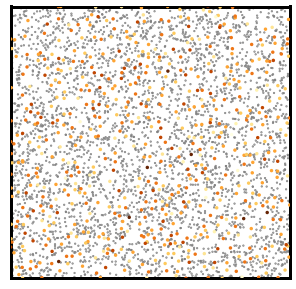

In [10]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(5*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
ax.set_xticks([])
ax.set_yticks([])
ax.margins(0)

ax.scatter(
    position[hi_mask][:,0], position[hi_mask][:,1], 
    marker='.', s=node_sizes[hi_mask], c=node_colors[hi_mask], zorder=4
)

ax.scatter(
    position[lo_mask][:,0], position[lo_mask][:,1], 
    marker='.', s=node_sizes[lo_mask], c=node_colors[lo_mask], zorder=1
)

line_collection = LineCollection(
    segments[es_hi_mask], linewidth=edge_lw[es_hi_mask], color=edge_colors[es_hi_mask], zorder=3
)
#ax.add_collection(line_collection)

line_collection = LineCollection(
    segments[es_lo_mask], linewidth=edge_lw[es_lo_mask], color=edge_colors[es_lo_mask], zorder=2
)
#ax.add_collection(line_collection)


fig_name = os.path.join(fig_dir, 'PRL_Fig0_a_{:.3f}'.format(q))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [20]:
print(g.degree_distribution())

N = 4096, mean +- sd: 5.9854 +- 1.3876
Each * represents 19 items
[ 3,  4): ** (45)
[ 4,  5): ************************** (498)
[ 5,  6): ******************************************************* (1055)
[ 6,  7): ************************************************************* (1165)
[ 7,  8): ***************************************** (791)
[ 8,  9): ******************* (371)
[ 9, 10): ***** (112)
[10, 11): ** (45)
[11, 12):  (9)
[12, 13):  (3)
[13, 14):  (2)


In [27]:
meank = np.mean(g.degree())
print(meank)
#vertices = [i for i, k in enumerate(g.degree()) if k >= meank]
vertices = [i for i, k in enumerate(g.degree()) if k >= 10]
h = g.subgraph(vertices)
h.summary()

5.9853515625


'IGRAPH U--- 59 19 -- '

In [5]:
net_type = 'DT'
param = 'param'
networks_dir = os.path.join('..', 'networks')
N = 512**2
print(N)
seed = 0

base_net_name, base_net_name_size = get_base_network_name(net_type, N, param)
net_name = base_net_name_size + '_{:05d}'.format(seed)
net_dir = os.path.join(networks_dir, net_type, base_net_name, base_net_name_size, net_name)

g = read_data_file(net_dir, net_name, reader='igraph')

262144


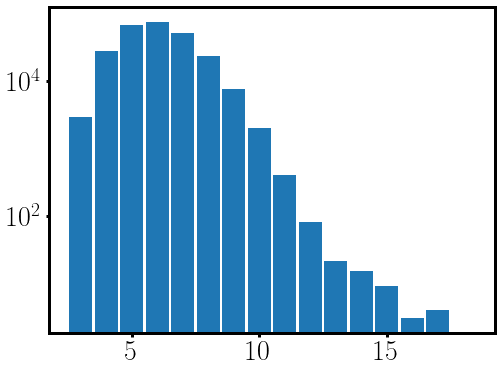

In [21]:
deg_seq = g.degree()

fig, ax = plt.subplots(figsize=(8,6))

freq, bins = np.histogram(deg_seq)

ax.hist(deg_seq, rwidth=0.9, bins=0.5+np.arange(2, max(deg_seq)+2))
ax.set_yscale('log')
plt.show()

In [22]:
min(deg_seq)

3